In [1]:
# Import 
import os
import time
import json
import random
import datetime
import numpy as np
import pandas as pd
import ipyvolume as ipv


from IPython.display import display, Image

from pathlib import Path

from tyssue import config
from tyssue import Sheet

from tyssue.io import hdf5, get_sim_dir
from tyssue.io.hdf5 import load_datasets

from tyssue.core.history import History, HistoryHdf5
from tyssue.utils.connectivity import edge_in_face_connectivity

from tyssue.dynamics import SheetModel as basemodel
from tyssue.dynamics import units, effectors, model_factory

from tyssue.solvers.quasistatic import QSSolver
from tyssue.solvers.viscous import EulerSolver

from tyssue.draw import sheet_view, browse_history
from tyssue.draw import highlight_faces, create_gif
from tyssue.generation import ellipsoid_sheet

from tyssue.behaviors.event_manager import EventManager
from tyssue.behaviors.sheet import actions, basic_events
#from tyssue.behaviors.sheet.apoptosis_events import apoptosis

from tyssue.utils.decorators import face_lookup

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
from polarity.dynamics import model, RadialTension
from polarity.dynamics import EllipsoidLameGeometry as geom

from polarity.apoptosis import apoptosis, apoptosis_patterning

from polarity.toolbox import (init,
                              define_fold_position,
                              apoptosis_ventral,
                              apoptosis_lateral,
                              apoptosis_dorsal,
                             )

In [3]:
today = datetime.date.today().strftime('%Y%m%d')
sim_save_dir = get_sim_dir()/f'{today}-ViscousSolver-Prepolarized_test'

try:
    os.mkdir(sim_save_dir)
except FileExistsError:
    pass

In [4]:
from polarity.dynamics import RadialTension
model = model_factory(
    [
        RadialTension,
        effectors.LineTension,
        effectors.FaceAreaElasticity,
        effectors.LumenVolumeElasticity,
    ])

In [5]:
pola_specs = {
    "face" : {
         "myosin" : 10.,
    },
    "edge" : {
         "myosin" : 1., 
         "desorption_rate" : 10., # to be updated with tension
         "absorption_rate" : 1.,
    },
    "settings" : {
         "susceptibility" : 5.0,
         "myo_dependence" : 0.1,
         "max_desorption_rate": 10.
    }
}


from tyssue.solvers.viscous import EulerSolver

def get_myo_matrix(sheet):
    ef_connect = edge_in_face_connectivity(sheet)
    mat = (- np.diag(sheet.edge_df["desorption_rate"])
           - ef_connect * sheet.edge_df['absorption_rate'].values[:, None])
    
    return mat


def edge_projected_stress(sheet, model):
    
    force = -model.compute_gradient(sheet)
    srce_force = sheet.upcast_srce(force)
    trgt_force = sheet.upcast_trgt(force)
    stress = (
        (srce_force - trgt_force) 
        * sheet.edge_df[['u'+c for c in sheet.coords]].values
    ).sum(axis=1)
    
    return stress


def update_chem(sheet, model):
    k_0 = sheet.settings["max_desorption_rate"]
    chi = sheet.settings["susceptibility"]
    myo_dep = sheet.settings["myo_dependence"]
    stress = edge_projected_stress(sheet, model)
    sheet.edge_df["desorption_rate"] = k_0 / (1 + np.exp(chi*stress))
    sheet.edge_df["line_tension"] = myo_dep * sheet.edge_df["myosin"]*400 #/ sheet.edge_df['length']


class EulerProtSolver(EulerSolver):
      
    def ode_func_prot(self):
        A = get_myo_matrix(self.eptm)
        B = self.eptm.upcast_face("myosin").values
        invA = np.linalg.inv(A)
        dot_n = np.linalg.solve(invA, self.eptm.edge_df['myosin']) + B 

        return dot_n
    

    def solve(self, tf, dt, on_topo_change=None, topo_change_args=()):
        """Solves the system of differential equations from the current time
        to tf with steps of dt with a forward Euler method.

        Parameters
        ----------
        tf : float, final time when we stop solving
        dt : float, time step
        on_topo_change : function, optional, default None
             function of `self.eptm`
        topo_change_args : tuple, arguments passed to `on_topo_change`

        """
        for t in np.arange(self.prev_t, tf + dt, dt):
            pos = self.current_pos
            myo = self.eptm.edge_df["myosin"]
            dot_r = self.ode_func(t, pos)


            if self.bounds is not None:
                dot_r = np.clip(dot_r, *self.bounds)
            pos += dot_r * dt
            self.set_pos(pos)
            
            dot_m = self.ode_func_prot()
            self.eptm.edge_df["myosin"] += dot_m * dt
            
            
            self.prev_t = t
            update_chem(self.eptm, self.model)
            
            if self.manager is not None:
                self.manager.execute(self.eptm)
                self.geom.update_all(self.eptm)
                update_chem(self.eptm, self.model)
                self.manager.update()

            if self.eptm.topo_changed:
                if on_topo_change is not None:
                    on_topo_change(*topo_change_args)
                self.eptm.topo_changed = False
            self.record(t)
            
    

In [6]:
# Init superegg tissue 
sheet = init(hf5_filename='tissue_prepolarized.hf5')

# Modify some initial settings
sheet.settings['geometry'] = "spherical"

sheet.edge_df.line_tension *= 40.

geom.update_all(sheet)

specs = {
    "vert": {
        "viscosity": 0.1
    },
    "face": {
        'radial_tension': 0.0,
    },        
    "settings": {
        'lumen_vol_elasticity': 1e-3
    }
}

sheet.update_specs(specs, reset=True)
sheet.update_specs(pola_specs, reset=True)


Reseting column viscosity of the vert dataset with new specs


### We first use quasistatic gradient descent to do a first return to equilibrium

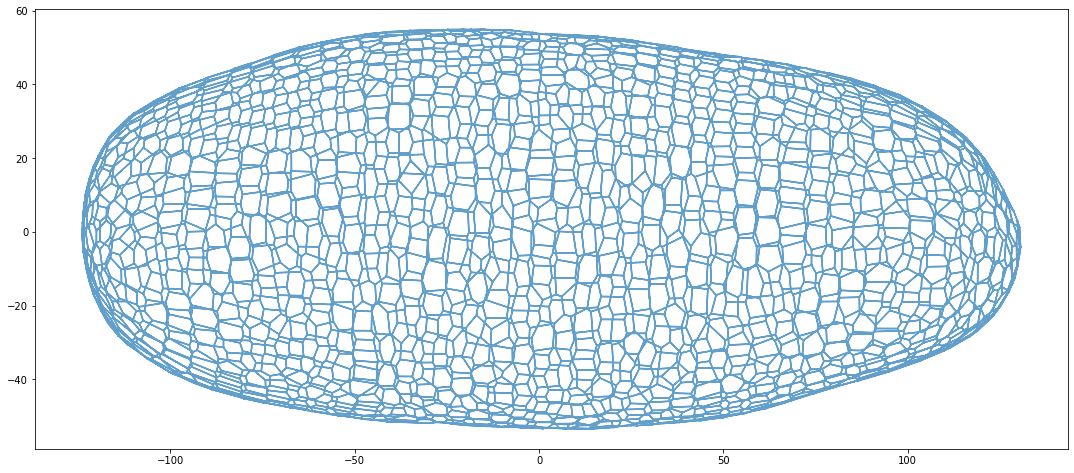

In [7]:
solver = QSSolver()
res = solver.find_energy_min(sheet, geom, model)
backup_sheet = sheet.copy()

fig, ax = sheet_view(sheet, ['z', 'x'], mode="quick", edge={"alpha":0.7})
fig.set_size_inches(18.5, 10.5, forward=True)

In [8]:
sheet = backup_sheet.copy()

In [9]:
model.labels


['Apical basal tension',
 'Line tension',
 'Area elasticity',
 'Lumen volume elasticity']

# Init basic information for fold formation

- position of the fold
- define 3 "categories" of apoptotic cells

In [10]:


define_fold_position(sheet, fold_number = 1, position=[-8, 8])
print(len(sheet.face_df[sheet.face_df.fold==1]))

ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color': edge_projected_stress(sheet, model),
                         'visible': True},
                   face={'color': sheet.face_df.fold,
                        'colormap':'Reds',
                        'visible':True})
fig


116


/home/admin-suz/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [11]:
from itertools import product

In [12]:
manager = EventManager('face')
manager.append(basic_events.reconnect)
    
#Initiate history to save all columns in all df
history = HistoryHdf5(
    sheet, 
    save_every=0.2,
    dt=0.1, 
    extra_cols={
        "face": sheet.coords+['area'],
        "edge": [u+c for u, c in product("stf", "xyz")]+['line_tension'],
        }, 
    hf5file="temp.hf5")

solver = EulerProtSolver(
    sheet,
    geom,
    model,
    history=history,
    manager=manager,
    bounds=(
        -sheet.edge_df.length.median()/10,
        sheet.edge_df.length.median()/10
    )
)



/home/admin-suz/anaconda3/lib/python3.7/site-packages/tyssue-0.5.0-py3.7-linux-x86_64.egg/tyssue/core/history.py:254: UserWarning: The file already exist and the new filename is temp2.hf5
  new_hf5file


In [13]:
sheet.vert_df['viscosity'] = 0.1

In [14]:
solver.solve(1, 0.1)

/home/admin-suz/anaconda3/lib/python3.7/site-packages/tyssue-0.5.0-py3.7-linux-x86_64.egg/tyssue/core/history.py:333: UserWarning: New columns {'srce_o', 'rho', 'height', 'basal_shift', 'viscosity', 'is_active', 'radial_tension'} will not be saved in the vert table
  diff_col, element
/home/admin-suz/anaconda3/lib/python3.7/site-packages/tyssue-0.5.0-py3.7-linux-x86_64.egg/tyssue/core/history.py:333: UserWarning: New columns {'cell', 'ux', 'is_active', 'cx', 'cy', 'absorption_rate', 'dy', 'myosin', 'sub_vol', 'face_o', 'id_', 'trgt_o', 'desorption_rate', 'nx', 'dz', 'srce_o', 'ny', 'cell_o', 'uy', 'uz', 'nz', 'edge_o', 'sub_area', 'dx', 'is_valid', 'cz', 'length'} will not be saved in the edge table
  diff_col, element
/home/admin-suz/anaconda3/lib/python3.7/site-packages/tyssue-0.5.0-py3.7-linux-x86_64.egg/tyssue/core/history.py:333: UserWarning: New columns {'opposite', 'is_alive', 'phi', 'contractility', 'area_elasticity', 'theta', 'prefered_area', 'id', 'vol', 'fold', 'rho', 'apopt

In [15]:
with pd.HDFStore(history.hf5file) as store:
    line_tension = store.select('edge', columns=['time', 'line_tension'])

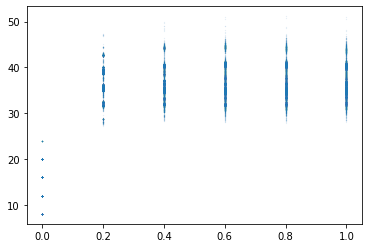

In [16]:
fig, ax = plt.subplots()
ax.plot(line_tension['time'], line_tension['line_tension'], '.', alpha=0.8, ms=0.1)

In [17]:
history = HistoryHdf5.from_archive(solver.history.hf5file)


specs = {
    "face": {
        "visible": True,
        "color": lambda sheet : sheet.face_df['area'],
        "colormap": 'viridis',
    },
    "edge": {
        "color": 'k'
    }
}


browse_history(history, coords=['z', 'x', 'y'], **specs)

interactive(children=(IntSlider(value=0, description='i', max=5), Output()), _dom_classes=('widget-interact',)…

In [18]:
sheet.face_df['apoptosis'] = 0
apoptosis_ventral(sheet, 1)
apoptosis_lateral(sheet, 1)
apoptosis_dorsal(sheet, 1)

ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':'lightslategrey',
                         'visible':True},
                   face={'color': sheet.face_df.apoptosis,
                        'colormap':'Reds',
                        'visible':True})
fig

print(len(sheet.face_df[sheet.face_df.fold>0]))
print(len(sheet.face_df[sheet.face_df.apoptosis>0]))
print(len(sheet.face_df[sheet.face_df.apoptosis==1]))
print(len(sheet.face_df[sheet.face_df.apoptosis==2]))
print(len(sheet.face_df[sheet.face_df.apoptosis==3]))


116
35
18
16
1


In [19]:
backupSheet2 = sheet.copy()

# Starting the viscous solver

In [20]:
default_pattern=    {
        "t":0,
        "dt":0.1
    }

from polarity.apoptosis import default_apoptosis_spec
from tyssue.behaviors.sheet.actions import (
    ab_pull,
    set_value,
    exchange,
    remove,
    decrease,
    increase_linear_tension,
)



def apoptosis_patterning(sheet, manager, **kwargs):
    """Apoptosis process patterning, which put cell in apoptosis progressively.


    """
    specs = default_pattern
    specs.update(**kwargs)
    # variable a passer en parametre?
    t = specs['t']
    
    #phi_min = -t*max(np.abs(sheet.face_df.phi))/120+max(np.abs(sheet.face_df.phi))
    phi_min = -t*max(np.abs(sheet.face_df.phi))/12+max(np.abs(sheet.face_df.phi))

    l_index_apoptosis_cell = sheet.face_df[(np.abs(sheet.face_df.phi)>phi_min) 
                                           & (sheet.face_df.apoptosis>0)
                                          ].index.values
    apopto_kwargs = sheet.settings['apoptosis'].copy()
    for c in l_index_apoptosis_cell:
        apopto_kwargs.update(
        {
            'face_id': c,
        }
        )
        manager.append(apoptosis, **apopto_kwargs)

    
    specs.update({"t" : specs['t']+specs['dt']})
    manager.append(apoptosis_patterning, **specs)


@face_lookup
def apoptosis(sheet, manager, **kwargs):
    """Apoptotic behavior

    While the cell's apical area is bigger than a threshold, the
    cell contracts, and the contractility of its neighbors is increased.
    once the critical area is reached, the cell is eliminated
    from the apical surface through successive type 1 transition. Once
    only three sides are left, the cell is eliminated from the tissue.

    Parameters
    ----------
    sheet : a :class:`Sheet` object
    manager : a :class:`EventManager` object
    face_id : int,
        the id of the apoptotic cell
    contract_rate : float, default 0.1
        the rate of reduction of the cell's prefered volume
        e.g. the prefered volume is devided by a factor 1+contract_rate
    critical_area : area at which the face is eliminated from the sheet
    radial_tension : amount of radial tension added at each contraction steps
    contractile_increase : increase in contractility at the cell neighbors
    contract_span : number of neighbors affected by the contracitity increase
    geom : the geometry class used
    """

    apoptosis_spec = default_apoptosis_spec
    apoptosis_spec.update(**kwargs)
    dt = sheet.settings.get('dt', 1.0)
    # Small variable name for some spec
    face = apoptosis_spec["face"]
    current_traction = apoptosis_spec["current_traction"]
    face_area = sheet.face_df.loc[face, "area"]

    if (face_area > apoptosis_spec["critical_area"]):
        # reduce prefered_area
        decrease(
            sheet,
            'face',
            face,
            apoptosis_spec["shrink_rate"],
            col="prefered_area",
            divide=True,
            bound=apoptosis_spec["critical_area"] / 2,
        )

        increase_linear_tension(
            sheet,
            face,
            apoptosis_spec['contract_rate'] * dt,
            multiple=True,
            isotropic=True,
            limit=100
        )

    if face_area < apoptosis_spec["critical_area"]:
        if current_traction < apoptosis_spec["max_traction"]:
            # AB pull
            set_value(sheet,
                      'face',
                      face,
                      apoptosis_spec['radial_tension'],
                      col="radial_tension")
            current_traction = current_traction + dt
            apoptosis_spec.update({"current_traction": current_traction})

        elif current_traction >= apoptosis_spec["max_traction"]:
            if sheet.face_df.loc[face, "num_sides"] > 3:
                exchange(sheet, face, apoptosis_spec["geom"])
            else:
                remove(sheet, face, apoptosis_spec["geom"])
                return

    manager.append(apoptosis, **apoptosis_spec)


In [21]:
def run_sim(sim_save_dir, sheet, constriction, radial_tension, iteration=0):
    
    hf5file = '{}_constriction_{}_radialtension.hf5'.format(
        constriction, radial_tension)
    hf5file = os.path.join(sim_save_dir, hf5file)
    
    try:
        os.mkdir(sim_save_dir)
    except IOError:
        pass
    
    apoptosis_settings = {
        "critical_area": 0.5,
        "contract_rate": constriction,
        "basal_contract_rate": 1.01,
        "shrink_span": 2,
        "radial_tension": radial_tension,
        "max_traction":10,
        "current_traction":0,
        "geom": geom,
    }

    # Add some information to the sheet and copy initial sheet
    sheet2 = sheet.copy(deep_copy=True)
    sheet2.face_df['id'] = sheet2.face_df.index.values
    sheet2.settings['apoptosis'] = apoptosis_settings
    

    #sheet2 = apoptosis_process(dirname, solver, sheet2)
    
    # Time property
    dt = 0.1       # time step
    rf = 1.        #record frequency
    tf = 200         #final time solving
    
    # Initiate manager
    manager = EventManager('face')
    manager.append(basic_events.reconnect)
    
    #Initiate history to save all columns in all df
    history = HistoryHdf5(
        sheet2, 
        save_every=rf,
        dt=dt, 
        extra_cols={
            "face": list(sheet2.face_df.columns),
            "edge": list(sheet2.edge_df.columns),
            "vert": list(sheet2.vert_df.columns)
            }, 
        hf5file=hf5file)
    print(sheet2.vert_df.columns)
    # Starting viscous solver
    solver = EulerProtSolver(
        sheet2,
        geom, 
        model,
        history=history,
        manager=manager,
        bounds=(
            -sheet2.edge_df.length.median()/10,
            sheet2.edge_df.length.median()/10
        )
    )

    manager.update()
    sheet2.vert_df['viscosity'] = 0.1
    
    
    # Solving part... 
    sheet2.settings["dt"] = dt
    
    manager.append(apoptosis_patterning)
    manager.update()
    
    
    # Fold process ~ 3H
    # Apoptotic process ~ 30min
    # -> apical constriction ~20min
    # -> force apico basal ~ 10min
    solver.solve(tf, dt)
    #save_sheet(solver.history, path=dirname, start_number=0, dt=dt)
    
    print(solver.history.time_stamps.shape)
    print('{} done'.format(hf5file))
    print('~~~~~~~~~~~~~~~~~~~~~\n')
    
    #libère la mémoire ? 
    #del solver
    
    return sheet2, solver

In [22]:
sheet2, solver = run_sim(sim_save_dir, sheet, 1.08, 30.0)

Index(['x', 'y', 'z', 'is_active', 'rho', 'height', 'basal_shift', 'srce_o',
       'radial_tension', 'viscosity'],
      dtype='object')
(201,)
/home/admin-suz/Documents/Simulations/20190905-ViscousSolver-Prepolarized_test/1.08_constriction_30.0_radialtension.hf5 done
~~~~~~~~~~~~~~~~~~~~~



In [23]:
history = HistoryHdf5.from_archive(
    "/home/admin-suz/Documents/Simulations/20190902-ViscousSolver-Prepolarized/1.005_constriction_0.1_radialtension.hf5")


specs = {
    "face": {
        "visible": True,
        "color": lambda sheet : sheet.face_df['apoptosis'],
        
        "colormap": 'viridis',
    },
    "edge": {
        "color": 'k'
    }
}


browse_history(history, coords=['z', 'x', 'y'], **specs)

OSError: ``/home/admin-suz/Documents/Simulations/20190902-ViscousSolver-Prepolarized/1.005_constriction_0.1_radialtension.hf5`` does not exist